## TASK 1 Simple image classification 

**This notebook holds an example of**, a complete forward-backward learning cycle through a very simple classification network. \
The network consists of:
- A simple feature extraction / convulutional and pooling layer.
- A classification layer: Feed forward neural network.

The task is individual, but cooperation is allowed. Only basic tools like numpy, matplotlib should be used (no tensorflow).

**Delivery:** Two notebooks.
- Complete example, focusing on clear explanation of solutions.
- ...and problem solving, where parts of the solution is hidden.

**Assesment:**
- Level of **explanation** and **correctness**. 
- Level Concreteness and detail.
- Simplicity: as simple as possible
- Complexness / difficulty: how complex was the implemented features.
- Creativity / originality.
- References and links to other work.



In [1]:
"""
My idea:
- Compare performance of basic ANN vs CNN + ANN on MNIST dataset!
"""

'\nMy idea:\n- Compare performance of basic ANN vs CNN + ANN on MNIST dataset!\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

"""
Basic utility functions for visualizing an "image".
"""

def visualize_image(X, label):
    # Plot "pixels" with numerical value and color map
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(1,1,1)
    ax.axis('off')
    ax.imshow(X, cmap="coolwarm")
    ax.title.set_text(label)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            ax.text(j, i, f"{X[i,j]:.2f}", color="black", fontsize="small", ha="center", va="center")

def convolution(X, F, b=0, s=1):
    # Convolutional layer
    # note: no padding and depth=1 just to make calculations a bit simpler
    # Output feature size
    w_out = (X.shape[0] - F.shape[0])//s + 1
    h_out = (X.shape[1] - F.shape[1])//s + 1
    z = np.zeros((h_out, w_out))
    for j in range(0, w_out, s):
        for i in range(0, h_out, s):
            z[i,j] = X[i:i+F.shape[1], j:j+F.shape[0]].flatten().dot(F.flatten()) + b
    return z

def max_pool(X, k, s):
    h_out = (X.shape[0] - k)//s + 1
    w_out = (X.shape[1] - k)//s + 1
    z = np.zeros((h_out, w_out))
    idx = []
    for j in range(0, h_out):
        for i in range(0, w_out):
            block = X[j*k:j*k+k, i*k:i*k+k]
            z[j,i] = np.max(block)
            index = np.add(np.unravel_index(block.argmax(), block.shape), (j*k, i*k))
            idx.append(index) # Save indices of max values for backward pass!
    return z, idx


In [3]:
"""
Different loss functions
"""

def ReLU(x):
    return abs(x) * (x > 0) # abs just makes -0.0 into 0.0 for easier reading
def d_ReLU(x): # differentiated!
    return 1 * (x > 0)
def sigmoid(x):
    y = np.exp(x)
    return y / (1 + y)
def d_sigmoid(x): # differentiated!
    y = sigmoid(x)
    return y * (1.0 - y)
def bce_loss(y, p):
    # Binary cross-entropy loss function
    return -(y * np.log10(p) + (1-y) * np.log10(1-p))
def d_bce_loss(y,p): # differentiated!
    # Derivative wrt. p
    return (1 - y) / (1 - p) - (y / p)


In [4]:
"""
Forward pass.
- Let X denote the input image assumed to be belonging to class
- We initialize the weights and bias in the convolutional layer (to some arbitrary values) and perform the forward pass through this layer:

"""
X = np.array([[2,1,0,2,1], [2,1,1,0,2], [1,2,0,1,0], [1,0,2,1,2], [2,1,1,0,0]])
y = 1

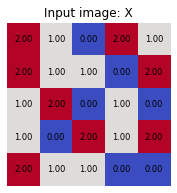

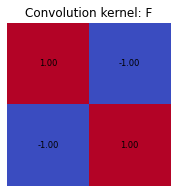

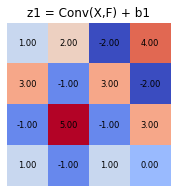

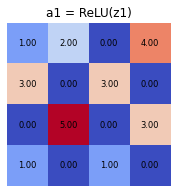

In [5]:

# Convolutional layer + ReLU activation function
F = np.array([[1,-1],[-1,1]]) # Kernel
b1 = 1.0 # Bias
z1 = convolution(X, F, b1, s=1) # Perform convolution
a1 = ReLU(z1) # Apply AF
visualize_image(X, "Input image: X")
visualize_image(F, "Convolution kernel: F")
visualize_image(z1, "z1 = Conv(X,F) + b1")
visualize_image(a1, "a1 = ReLU(z1)")

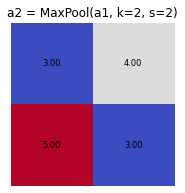

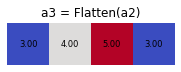

In [6]:
"""
We now apply max pooling and flatten the output of our feature extractor before passing it to the fully-connected layer:
"""

# MaxPool + Flatten
a2, max_idx = max_pool(a1, k=2, s=2)
a3 = a2.flatten()
visualize_image(a2, "a2 = MaxPool(a1, k=2, s=2)")
visualize_image(a3.reshape(1,4), "a3 = Flatten(a2)")


In [7]:
"""
We initialize the weights and bias of the fully-connected layer and perform the forward pass. We also compute the binary cross-entropy loss:
"""
# Fully-connected layer
w4 = np.array([-1, 1, -1, 1]) # Weights
b4 = 0 # Bias
z4 = w4.dot(a3) + b4
a4 = sigmoid(z4)
print(f"Activation after fully-connected layer: {a4:.2f}")
loss = bce_loss(y, a4)
print(f"Binary cross-entropy loss: {loss:.2f}")

Activation after fully-connected layer: 0.27
Binary cross-entropy loss: 0.57


### Backwards pass

- **Backprop**. starting from the fully connected layer, going back to pooling and convolution in the end.\
![Delta](images/backpass_delta.png)
- **Apply chain rule:** \
![Chain](images/chain_ruled.png)

In [8]:
lr = 0.1 # Leanring rate
# Fully connected layer:
delta = d_bce_loss(1, a4) * d_sigmoid(z4)
print(f"dL / d(b4) = {delta:.2f}")
#b4 = b4 - lr * delta # Update bias
delta = delta * a3 # Gradient wrt. w4
print(f"dL / d(w4) = {np.round(delta, 2)}")
#w4 = w4 - lr * delta # Update weights


dL / d(b4) = -0.73
dL / d(w4) = [-2.19 -2.92 -3.66 -2.19]


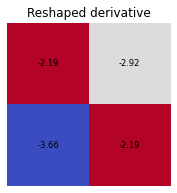

In [9]:
### NEXT, we unflatten the backpropagated derivative:
delta = delta.reshape(a2.shape)
visualize_image(delta, "Reshaped derivative")

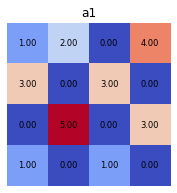

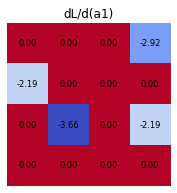

In [10]:
""" We now backpropagate through the max pooling layer. 
Only the entries appearing as maximum values in the forward pass affects the output of the
max pooling layer (with a factor of ). Consequently, we get that can be computed as follows:
"""
d = np.zeros(a1.shape)
for idx, grad in zip(max_idx, delta.flatten()):
    i, j = idx[0], idx[1]
    d[i,j] = grad
delta = d
visualize_image(a1, "a1")
visualize_image(delta, "dL/d(a1)")

In [11]:
# WE see that only the max-tiles are affected
max_idx

[array([1, 0], dtype=int64),
 array([0, 3], dtype=int64),
 array([2, 1], dtype=int64),
 array([2, 3], dtype=int64)]

**Next, we backpropagate through the ReLU activation function.**

The ReLU has slope  for non-negative inputs and slope for negative inputs. The
derivative is implemented in d_ReLU(). \
![RELU](images/ReLU.png)

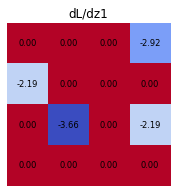

In [12]:
delta = d_ReLU(z1) * delta
visualize_image(delta, "dL/dz1")

**Conv-layer backprop is a bit harder:**
![RELU](images/conv_backprop.png)

In [13]:
## First for the biases

grad_b1 = delta.sum() # dL/d(b1)
print(f"dL / d(b1) = {grad_b1:.2f}")
#b1 = b1 - lr * grad_b1 # Update bias


dL / d(b1) = -10.97


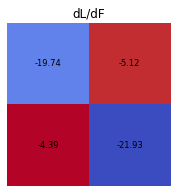

In [14]:
## Now for the convolutional kernel
grad_F = np.zeros(F.shape)
grad_F[0,0] = np.sum(X[0:4, 0:4] * delta)
grad_F[0,1] = np.sum(X[0:4, 1:5] * delta)
grad_F[1,0] = np.sum(X[1:5, 0:4] * delta)
grad_F[1,1] = np.sum(X[1:5, 1:5] * delta)
# F = F - lr * grad_F # Update weights
visualize_image(grad_F, "dL/dF")

#### Derivation as convolution:
Note that we can also realize the above formulas for computing dL/dF as a convolution!\
![Deriv](images/deriv_as_conv.png)

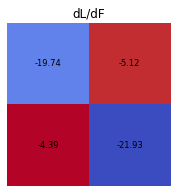

In [15]:
grad_F = convolution(X, delta)
visualize_image(grad_F, "dL/dF")